In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Till Leissner
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Till Leissner (University of Southern Denmark)
#   Edited by: 
#
#   We acknowledge support from the ESS Lighthouse on Hard Materials in 3D, SOLID, funded by the Danish Agency for Science and Higher Education (grant No. 8144-00002B).

In [2]:
### General imports 
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#import json

### Import all CIL components needed
import cil
from cil.framework import ImageData, ImageGeometry
from cil.plugins import tigre
from cil.io import TIFFWriter, TIFFStackReader
from cil.processors import CentreOfRotationCorrector, Binner, TransmissionAbsorptionConverter,RingRemover, Slicer
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry

### Import custom helper functions
import sys
sys.path.append("../../") # Adds higher directory to python modules path.
import bruker2cil as bc

# This notebook has been tested with CIL version 24.0.0
print(cil.__version__)

/work/envs/cil24.3/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


24.3.0


# Introduction

This notebook showcases the volume reconstruction of microCT projection data obtained with a *Bruker Skyscan 2214* using a flat panel detector and a source voltage of 125 kV at 69 µA. Projections are available as 16-bit tiffs. The image normalisation 

$$ \frac{(projection - darkfield)}{(flatfield - darkfield)} $$

has been already applied during the data aquisition. All files created during a scan are located in a single flat folder. 

This notebooks showcases:

<p>
    
- **04-citron**: a 180 deg scan of a citron

The data set is available a compressed zip archives on [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11258475.svg)](https://doi.org/10.5281/zenodo.11258475)


# Set variables and paths

To get started a few path variables have to be defined:

In [3]:
datadir = '../../samples/04-citron' # Path to the dataset
dataset_prefix = '001' # Filename prefix

# Usually you do not need to change the following. 
infofile = os.path.join(datadir,dataset_prefix+'.info') 
logfile = os.path.join(datadir,dataset_prefix+'.log') 

# Create acquisition geometry

The function *set_geometry* will parse the ".info" and the ".log" files, determine the scan parameters and create the corresponding CIL acquisition geometry.

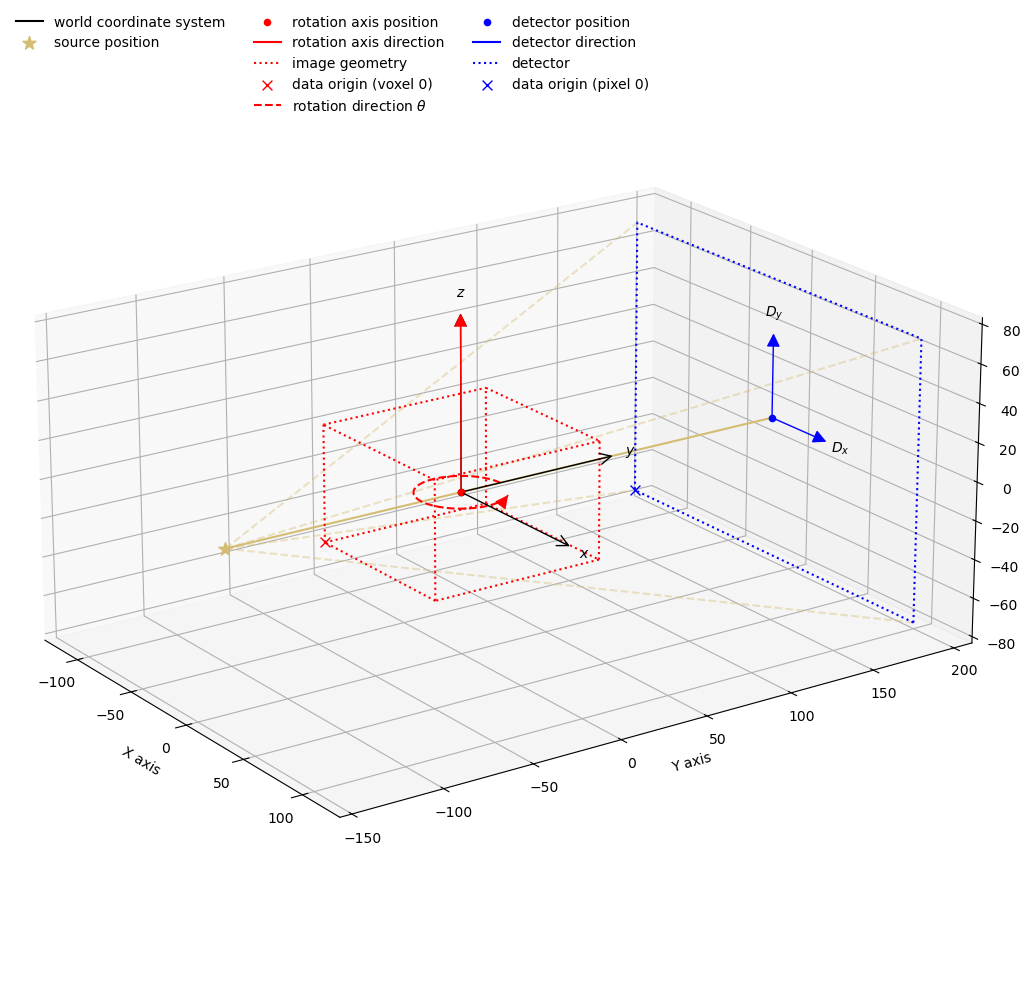

In [4]:
ag = bc.set_geometry(logfile,infofile=infofile) # This will use the info file to determine the actually achieved projection angles
#ag = bc.set_geometry(logfile) # This will use the angular step size from the log file to determine the projection angles
show_geometry(ag,grid=True)

# Read files

The helper function get_filelist will create a list of projection files. Further I check if the number of images corresponds to the number of angles obtained from the .info file. Afterwards the images are loaded using the CIL TIFFStackReader class.

In [5]:
filelist = bc.get_filelist(datadir,dataset_prefix)
#print(filelist)
if len(ag.angles) != len(filelist):
    print('Warning: Number of files does not correspond to number of rotational steps!')

In [6]:
reader = TIFFStackReader(file_name=filelist)

In [7]:
proj = reader.read_as_AcquisitionData(ag)
projbak = proj # keep a copy of the original data set

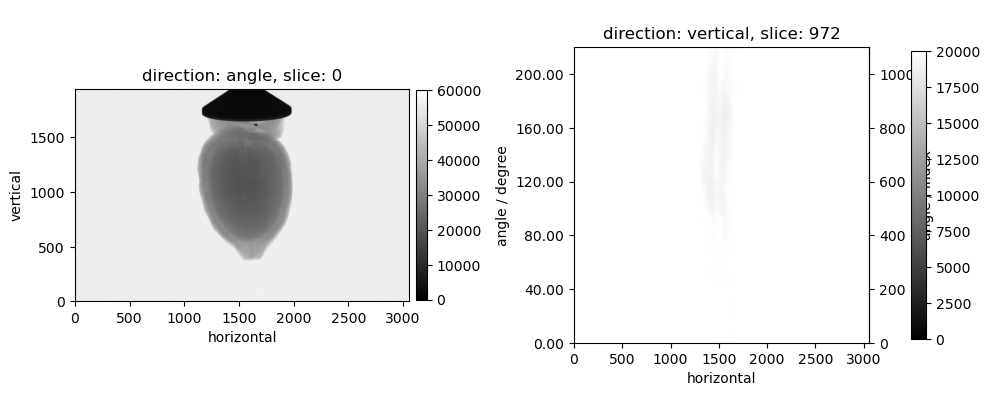

In [8]:
proj =projbak
fig = show2D(proj, slice_list=[('angle',0),('vertical', np.floor_divide(proj.shape[1],2))], size=(10,10), num_cols=2, cmap="gray", fix_range=[(0,60000),(0,20000)])

DEBUG:cil.processors.CofR_image_sharpness:Initial search:
DEBUG:cil.processors.CofR_image_sharpness:search range is 10
DEBUG:cil.processors.CofR_image_sharpness:initial binning is 2


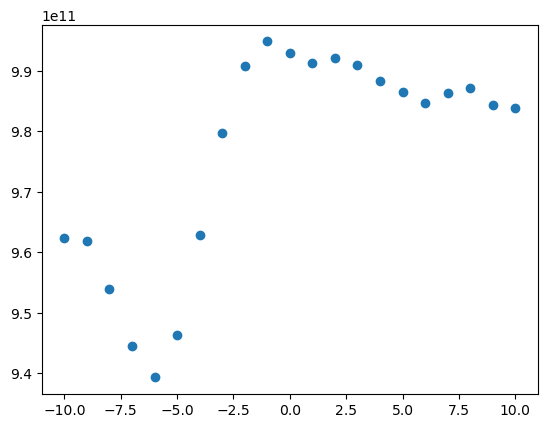

DEBUG:cil.processors.CofR_image_sharpness:fine search starting at -0.188240
DEBUG:cil.processors.CofR_image_sharpness:GSS between -0.250241 and -0.126240
INFO:cil.processors.CofR_image_sharpness:evaluated 13 points


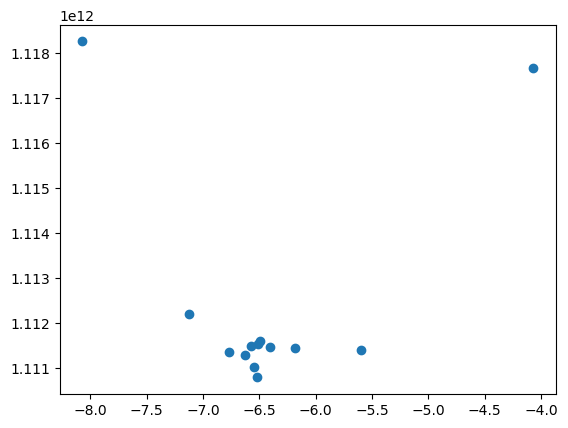

INFO:cil.processors.CofR_image_sharpness:Centre of rotation correction found using image_sharpness
INFO:cil.processors.CofR_image_sharpness:backend FBP/FDK tigre
INFO:cil.processors.CofR_image_sharpness:Calculated from slice: centre
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = -6.531592 pixels
INFO:cil.processors.CofR_image_sharpness:Centre of rotation shift = -0.202480 units at the object
INFO:cil.processors.CofR_image_sharpness:Return new dataset with centred geometry


In [9]:
### Optional: Apply Centre of Rotation Corrector

### Turn this on for more info
import logging
logging.basicConfig(level=logging.WARNING)
cil_log_level = logging.getLogger('cil.processors')
cil_log_level.setLevel(logging.DEBUG)

processor = CentreOfRotationCorrector.image_sharpness(slice_index='centre', backend='tigre', tolerance=0.05, initial_binning=2, search_range=10) 
processor.set_input(proj) 
processor.get_output(out=proj)

In [10]:
### Optional: Slicing
### This will remove projection data that does not contain any information. This will save computational effort.
#roi = {'horizontal':(900,-900),'angle':(0,np.argwhere(ag.angles==180)+1)} # Use intervall (0,180) deg for reconstruction.

roi = {'horizontal':(900,-900),'vertical':(0,1500)} # Use intervall (0,180) deg for reconstruction.
processor = Slicer(roi)
processor.set_input(proj)
proj = processor.get_output()

In [11]:
### Optional: Ring artefact removal

#processor = RingRemover(decNum=4, wname='db35', sigma=1.5, info=True)
#processor.set_input(proj)
#proj = processor.get_output()

In [12]:
### Optional: Data binning

roi = {'horizontal':(None,None,2),'vertical':(None,None,2)}
processor = Binner(roi)
processor.set_input(proj)
proj = processor.get_output()

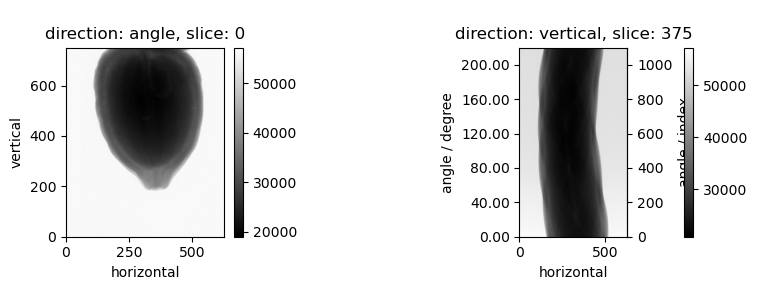

In [13]:
# Let's plot the data set after applying of thoprocessors:
fig = show2D(proj, slice_list=[('angle',0),('vertical', np.floor_divide(proj.shape[1],2))], size=(10,3), num_cols=2, cmap="gray")

Min grey value 16083.5
Max grey value 57441.25


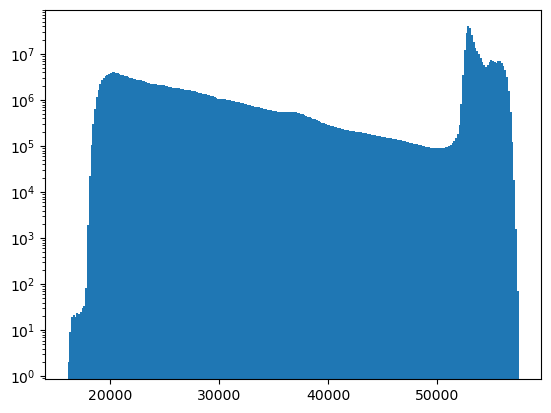

In [14]:
plt.hist(proj.as_array().flatten(),bins=256);
plt.semilogy()

print(f'Min grey value {proj.min()}')
print(f'Max grey value {proj.max()}')

In [15]:
# Substract Background
background = proj.get_slice(vertical=20, force=True).mean()
proj /= background

In [16]:
# Prepare data for reconstruction
proj = TransmissionAbsorptionConverter(min_intensity=1e-6)(proj)
proj.reorder(order='tigre')
ig = proj.geometry.get_ImageGeometry()

# Review projection data before running the recontruction

In [17]:
# Let's summarize the used geometries before we start the reconstruction.
print('Acquisition geometry:\n',ag,end='\n\n')
print('Projection geometry:\n',proj,end='\n\n')
print('Image geometry:\n',ig)

Acquisition geometry:
 3D Cone-beam tomography
System configuration:
	Source position: [   0.  , -133.04,    0.  ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [  0.   , 187.972,   0.   ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [3056 1944]
	Pixel size: [0.0748 0.0748]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 1100
	Angles 0-9 in degrees: [0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]
	Angles 1090-1099 in degrees: [218. , 218.2, 218.4, 218.6, 218.8, 219. , 219.2, 219.4, 219.6, 219.8]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance

Projection geometry:
 Number of dimensions: 3
Shape: (1100, 750, 628)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZO

Min grey value -0.06665527820587158
Max grey value 1.2063134908676147


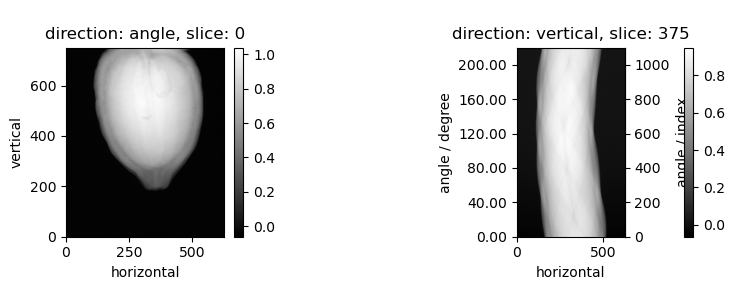

In [18]:
print(f'Min grey value {proj.min()}')
print(f'Max grey value {proj.max()}')
show2D(proj, slice_list=[('angle',0),('vertical', np.floor_divide(proj.shape[1],2))], size=(10,3))

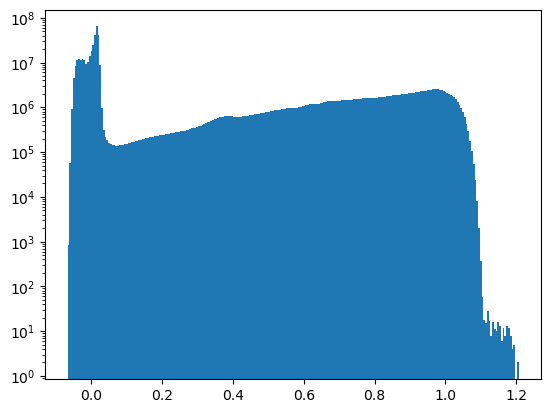

In [19]:
plt.hist(proj.as_array().flatten(),bins=256);
plt.semilogy();

# Perform reconstruction

In [20]:
fdk =  FDK(proj, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 1100
	vertical: 750
	horizontal: 628

Reconstruction Volume:
	vertical: 750
	horizontal_y: 628
	horizontal_x: 628

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



# Display results

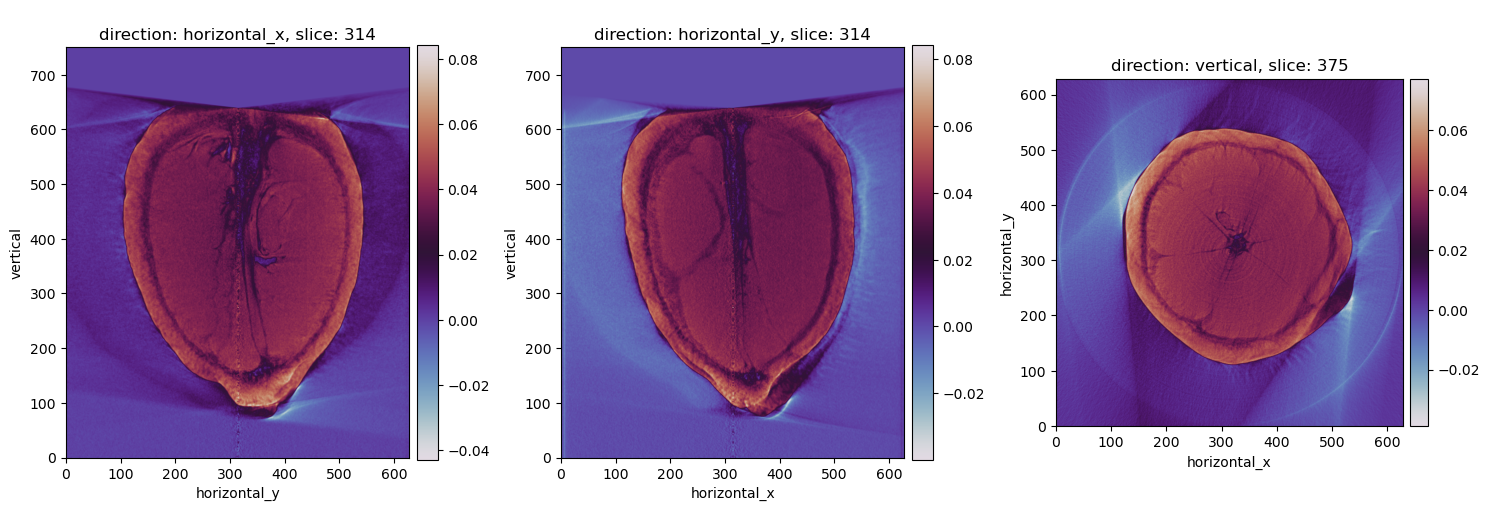

In [21]:
show2D(recon, slice_list= \
       [('horizontal_x', np.floor_divide(ig.shape[2],2)), \
        ('horizontal_y', np.floor_divide(ig.shape[1],2)), \
        ('vertical', np.floor_divide(ig.shape[0],2))], \
        num_cols=3, \
        cmap="twilight",
        )

# Save results as tiff files

In [22]:
# Save data to a subfolder of the data folder
subfolder = dataset_prefix+'Rec'
TIFFWriter(data=recon, file_name=os.path.join(datadir,subfolder,dataset_prefix),compression='uint8').write()

In [23]:
import json
# Save to a JSON file
with open(os.path.join(datadir,subfolder,dataset_prefix+'_params.json'), 'w') as fp:
    json.dump(bc.get_scanparams(logfile), fp, indent=4)